In [1]:
import stlab
import stlabutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = '/home/student/thesis/sidebanddata.dat'
mydata = stlabutils.readdata.readdat(filepath)

['Frequency (Hz)', 'B_1re ()', 'B_1im ()', 'B_1dB (dB)', 'B_1Ph (rad)', 'Power (dBm)']


In [3]:
for line in mydata:
    line['S21_lin ()'] = (line['B_1re ()']**2 + line['B_1im ()']**2)
# for line in mydata:
#     line['S21_lin ()'] = 10**((line['B_1dB (dB)']-30.)/10.)

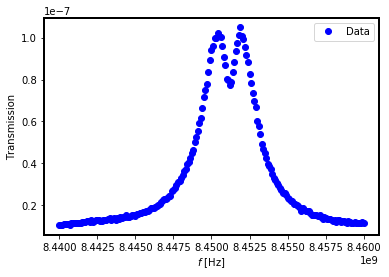

In [12]:
block = mydata[20]
xdata = np.asarray(block['Frequency (Hz)'])
ydata = np.asarray(block['S21_lin ()'])
plt.figure()
plt.plot(xdata, ydata,'bo', label='Data')
plt.xlabel("$f$ [Hz]")
plt.ylabel("Transmission")
plt.legend()
# plt.xlim(8.447e9,8.455e9)
# plt.ylim(-80,-69)
plt.show()
plt.close()

# Tentative fit

In [5]:
from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *
from scipy import signal
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

In [6]:
def spectroscopy(wd_list, gamma, gamma_phi, g, A, B):
    
    #qubit (a)
    wq = 2*pi*8.4512e9
    Aq = 2*pi*135e6
    Nl_spec = 5
    
    #cavity (b)
    wc = 2*pi*8.4512e9
    kappa = 2*pi*3.133e6
    kappa_out = 2*pi*1e6
    kappa_in = 2*pi*0.333e6 
    Nh_spec = 5
    chi = 1*pi*678e+3
    
    power = -200 #low power limit [dB]
    P = np.power(10.,(float(power)-30.)/10.)  # convert dBm to Watts
    
    wd_list = wd_list*2*pi  # from Hz to rad/s
    
    # Hamiltonian diagonalization
    a = tensor(destroy(Nl_spec), qeye(Nh_spec))
    b = tensor(qeye(Nl_spec), destroy(Nh_spec))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]
    H0 = (wq)*num_a + (wc)*num_b - 0.5*Aq*a.dag()*a.dag()*a*a - g*(a.dag()*b + b.dag()*a)
    #    qubit        cavity       anharmonicity                coupling
    
    for wd in wd_list:
        eps = np.sqrt(P*(kappa_in)/hbar/wd) # 
        H = H0 - wd*num_a - wd*num_b + eps*1j*(b.dag()-b) - chi*num_a*num_b
        #        drive      drive      drive                state-dependent frequency shift
        c_ops = [np.sqrt(gamma)*a, np.sqrt(gamma_phi)*num_a, np.sqrt(kappa)*b]  
        rho_ss = steadystate(H, c_ops)  ## steady-state since interested in f-domain
        r.append(([np.absolute(expect(num_b,rho_ss))]))
    
    out = A*np.array(r)*(kappa_out*hbar*wd/P) +B
    return np.concatenate(out)

1.29444558005e-15


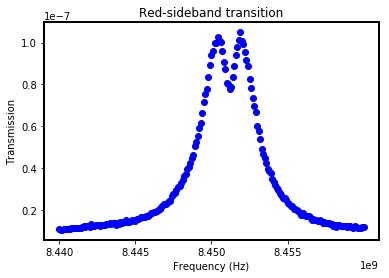

In [7]:
#qubit (a)
gamma = 2*pi*0.14e6 ##homogenous linewidth
gamma_phi = 2*pi*0.8e6 ##inhomogenous linewidth

#cavity (b)
g = 2*pi*0.64e+6 ##coupling constant

w_points = 201
wd_list = np.linspace(8.44e9, 8.46e9,w_points)  # Hz
A = 0.93e-6
B = 6e-9
byoungmoo = spectroscopy(xdata, gamma, gamma_phi, g, A, B)
cost = sum(abs(ydata - byoungmoo)**2)
print(cost)

plt.figure()
plt.plot(xdata, ydata,'bo')
plt.plot(xdata, byoungmoo,'r-')
# plt.xlim(8.445e9,8.457e9)
# plt.ylim(1.5e-4,3.5e-4) 
plt.xticks(np.arange(8.44e9,8.46e9, step=5e6))
plt.title('Red-sideband transition')
plt.xlabel('Frequency (Hz)')  
plt.ylabel('Transmission') 
plt.show()
plt.close()

In [8]:
costfun = lambda x1, x2 : sum(abs(x1 - x2)**2)

def sgd(x, ydata, model, costfun, p0, step):
    """Sequential gradient decent over all parameters of the model function."""
    from copy import copy
    finish = False
    paramvals = copy(p0)
    sim_init = model(x, p0[0], p0[1], p0[2], p0[3], p0[4])
    cost = costfun(ydata, sim_init)
    while not finish:
        changes = [False, False, False, False, False]
        for ipar in range(len(paramvals)):
            argsmin = copy(paramvals)
            argsmin[ipar] = paramvals[ipar] - step[ipar]
            if argsmin[ipar] < 0:
                argsmin[ipar] = 0
            argsplus = copy(paramvals)
            argsplus[ipar] = paramvals[ipar] + step[ipar]
            
            simmin = model(x, argsmin[0], argsmin[1], argsmin[2], argsmin[3], argsmin[4])
            simplus = model(x, argsplus[0], argsplus[1], argsplus[2], argsplus[3], argsplus[4])
            
            costmin = costfun(ydata, simmin)
            costplus = costfun(ydata, simplus)
            smallest = min([costmin, costplus])
            
            if (smallest == costmin and smallest < cost):
                stepdir = -step[ipar]
                paramvals[ipar] -= step[ipar]
                cost = copy(costmin)
                changes[ipar] = True
            elif (smallest == costplus and smallest < cost):
                stepdir = step[ipar]
                paramvals[ipar] += step[ipar]
                cost = copy(costplus)
                changes[ipar] = True
            elif (smallest > cost):
                stepdir = 0
            
            print(paramvals, cost)
            
            if stepdir != 0:
                descending = True
                while descending:
                    args = copy(paramvals)
                    args[ipar] += stepdir
                    if args[ipar] < 0:
                        args[ipar] = 0
                        descending = False
                    sim = model(x, args[0], args[1], args[2], args[3], args[4])
                    newcost = costfun(ydata, sim)
                    if newcost <= cost:
                        paramvals[ipar] = args[ipar]
                        cost = copy(newcost)
                    elif newcost > cost:
                        descending = False
                    
                    print(paramvals, cost)
            
        if True not in changes:
            finish = True
            print("Finished at local minimum")
    
    return paramvals

In [10]:
vals = sgd(xdata, ydata, spectroscopy, costfun,
           p0=[6e-8, 5385548.0, 4032238.0, 8.29e-7, 7.9e-9],
           step=[1e-9, 1e3, 1e3, 1e-9, 1e-10])

[5.899999999999999e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.799999999999999e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.699999999999999e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.5999999999999985e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.499999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09] 4.51445554162e-16
[5.

[5.399999999999998e-08, 5385548.0, 4032238.0, 8.29e-07, 7.9e-09]
[879645.943005142, 5026548.245743669, 4021238.5965949353, 9.3e-07, 6e-09]


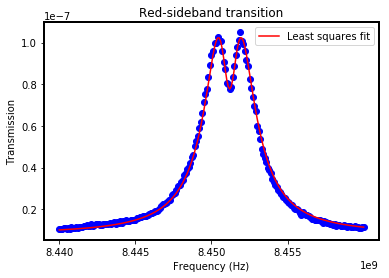

In [11]:
print(vals)
print([gamma, gamma_phi, g, A, B])

wouter = spectroscopy(xdata, vals[0], vals[1], vals[2], vals[3], vals[4])
wouter = spectroscopy(xdata, 0, 0.8572e6*2*pi, 0.6417e6*2*pi, 0.829e-6, 7.9e-9)

plt.figure()
# plt.plot(wd_list/2/pi,0.93e-6*sim+6e-9,'r-')
plt.plot(xdata, ydata,'bo')
# plt.plot(xdata, byoungmoo, 'k-', label='Byoung-moo')
plt.plot(xdata, wouter, 'r-', label='Least squares fit')
# plt.xlim(8.445e9,8.457e9)
# plt.ylim(1.5e-4,3.5e-4) 
plt.xticks(np.arange(8.44e9,8.46e9, step=5e6))
plt.title('Red-sideband transition')
plt.xlabel('Frequency (Hz)')  
plt.ylabel('Transmission')
plt.legend()
plt.show()
plt.close()

In [9]:
smodel = Model(spectroscopy)
result = smodel.fit(ydata, wd_list=xdata,
                    gamma=0, gamma_phi=gamma_phi, g=g, A=A, B=B,
                    nan_policy='omit', method='leastsq')
print(result.fit_report())

In [9]:
def scipy_costfun(x1, x2):
    

scipy_result = minimize(scipy_costfun, ydata, )

RuntimeError: Factor is exactly singular

In [160]:
plt.figure()
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, result.best_fit, 'r-', label='Wouter')
plt.plot(xdata, result.init_fit, 'g-', label='Byoung-moo')
plt.legend()
plt.show()

# FOURIER

In [57]:
def spectroscopyFT(wd_list, gamma, gamma_phi, g):
    
    #qubit (a)
    wq = 2*pi*8.4512e9
    Aq = 2*pi*135e6
    Nl_spec = 5
    
    #cavity (b)
    wc = 2*pi*8.4512e9
    kappa = 2*pi*3.133e6
    kappa_out = 2*pi*1e6
    kappa_in = 2*pi*0.333e6 
    Nh_spec = 5
    
    chi = 1*pi*678e+3
    power = -200 #low power limit
    
    wd_list = wd_list*2*pi
    
    P = np.power(10.,(float(power)-30.)/10.)  # convert dBm to Watts

# Hamiltonian diagonalization
    a = tensor(destroy(Nl_spec), qeye(Nh_spec))
    b = tensor(qeye(Nl_spec), destroy(Nh_spec))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]

    H0 = (wq)*num_a+(wc)*num_b-0.5*Aq*a.dag()*a.dag()*a*a -g*(a.dag()*b+b.dag()*a)
    for wd in wd_list:
        eps = np.sqrt(P*(kappa_in)/hbar/wd) # 

        H = H0 
        H -= wd*num_a
        H -= wd*num_b
        H += +eps*1j*(b.dag()-b)
        H -= chi*num_a*num_b

        c_ops = []
        c_ops.append(np.sqrt(gamma)*a)
        c_ops.append(np.sqrt(gamma_phi)*num_a)
        c_ops.append(np.sqrt(kappa)*b)
  
    
        rho_ss = steadystate(H, c_ops)
#         r.append([20.*np.log(np.absolute(expect(b*sqrt(hbar*wc*(kappa_out)/P),rho_ss)))])
        r.append(([np.absolute(expect(num_b,rho_ss))]))
    
    out = fft(np.array(r)*(kappa_out*hbar*wd/P))
    print("spectrocopyFT function called")

    return np.concatenate(out)

In [66]:
ydataft = fft(ydata)

params = Parameters()
params.add('gamma', min=0, max=1e-6*2*pi, brute_step=2e-7*2*pi)
params.add('gamma_phi', min=0, max=1e-6*2*pi, brute_step=2e-7*2*pi)
params.add('g', min=0, max=1e6*2*pi, brute_step=2e5*2*pi)

sftmodel = Model(spectroscopyFT)
params = sftmodel.make_params(gamma=gamma, gamma_phi=gamma_phi, g=g)
params['gamma'].min = 9e6
params['gamma'].max = 5e7
params['gamma'].brute_step = 4e6
params['gamma_phi'].min = 1e6
params['gamma_phi'].max = 1e7
params['gamma_phi'].brute_step = 2e6
params['g'].min = 9e6
params['g'].max = 5e7
params['g'].brute_step = 4e6
resultft = sftmodel.fit(ydataft, wd_list=xdata, params=params,
                        nan_policy='omit', method='brute')
print(resultft.fit_report())

spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocopyFT function called
spectrocop

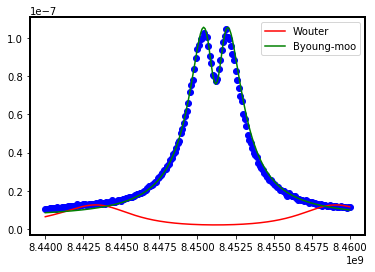

In [67]:
plt.figure()
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, 1e-6*resultft.best_fit, 'r-', label='Wouter')
plt.plot(xdata, sim, 'g-', label='Byoung-moo')
plt.legend()
plt.show()

In [30]:
def costFT(wd_list, gamma, gamma_phi, g):
    return sum(abs(ydata - spectroscopy(wd_list, gamma, gamma_phi, g)))